Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# save plots
PLOTS_PATH = "./plots/"
os.makedirs(PLOTS_PATH, exist_ok=True)

In [2]:
## utility functions

## package handler func
def verify_installation(package='Augmentor'):
    try:
        __import__(package)
        print(f"{package} package installed already")
        return True
    except ImportError:
        print(f"Requires installing {package} package")
        return False

## CNN architecture visualizer
def visualize_model(model, save_loc='model_just_layers.png'):
    save_loc = PLOTS_PATH + save_loc
    font = PIL.ImageFont.truetype("arial.ttf", 12)  # using comic sans is strictly prohibited!
    visualkeras.layered_view(model, legend=True, font=font, to_file=save_loc, scale_xy=1, scale_z=1, max_z=100)
    display(PIL.Image.open(save_loc))

In [3]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
DATA_PATH = r'../data/'
data_dir_train = pathlib.Path(DATA_PATH+'/Train/')
data_dir_test = pathlib.Path(DATA_PATH+'/Test/')

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=DATA_PATH+'/Train/',
    labels="inferred",
    color_mode='rgb',
    shuffle=True,
    seed=123,
    validation_split=.2,
    image_size=(img_height, img_width),
    subset='training',
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=DATA_PATH+'/Train/',
    labels="inferred",
    color_mode='rgb',
    shuffle=True,
    seed=123,
    validation_split=.2,
    image_size=(img_height, img_width),
    subset='validation',
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

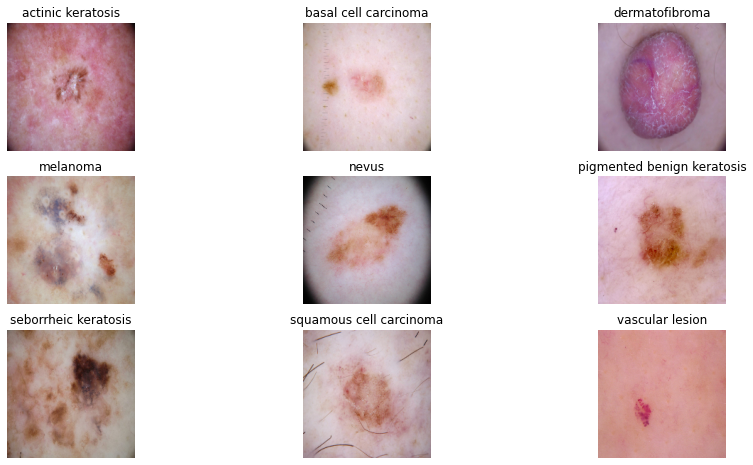

In [10]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(15, 8))
for i in range(len(class_names)):
    filtered_ds = train_ds.filter(lambda x, l: tf.math.equal(l[0], i))
    for img, label in filtered_ds.take(1):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(img[0].numpy().astype("uint8"))
        plt.title(class_names[label[0]])
        plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [12]:
### Your code goes here
normalization_layer = tf.keras.layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9992377


In [13]:
num_classes = 9

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [14]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Train the model

In [15]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 6s 35ms/step - loss: 2.0500 - accuracy: 0.2132 - val_loss: 1.9649 - val_accuracy: 0.3043
Epoch 2/20
56/56 [==============================] - 1s 23ms/step - loss: 1.8749 - accuracy: 0.3092 - val_loss: 1.7434 - val_accuracy: 0.3647
Epoch 3/20
56/56 [==============================] - 1s 23ms/step - loss: 1.6245 - accuracy: 0.4403 - val_loss: 1.4953 - val_accuracy: 0.4899
Epoch 4/20
56/56 [==============================] - 1s 22ms/step - loss: 1.4868 - accuracy: 0.4844 - val_loss: 1.4537 - val_accuracy: 0.4922
Epoch 5/20
56/56 [==============================] - 1s 22ms/step - loss: 1.3670 - accuracy: 0.5179 - val_loss: 1.4128 - val_accuracy: 0.5145
Epoch 6/20
56/56 [==============================] - 1s 23ms/step - loss: 1.3976 - accuracy: 0.5056 - val_loss: 1.4474 - val_accuracy: 0.5123
Epoch 7/20
56/56 [==============================] - 1s 22ms/step - loss: 1.2457 - accuracy: 0.5636 - val_loss: 1.4176 - val_accuracy: 0.5078
Epoch 8/20
56

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 32)        9

In [17]:
if not verify_installation(package="visualkeras"):
    !pip install visualkeras

import visualkeras

visualkeras package installed already


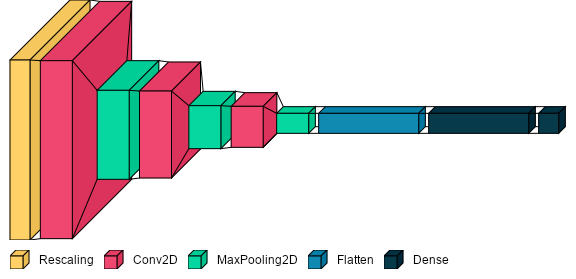

In [18]:
visualize_model(model=model, save_loc="initial_model_cnn.png")

### Visualizing training results

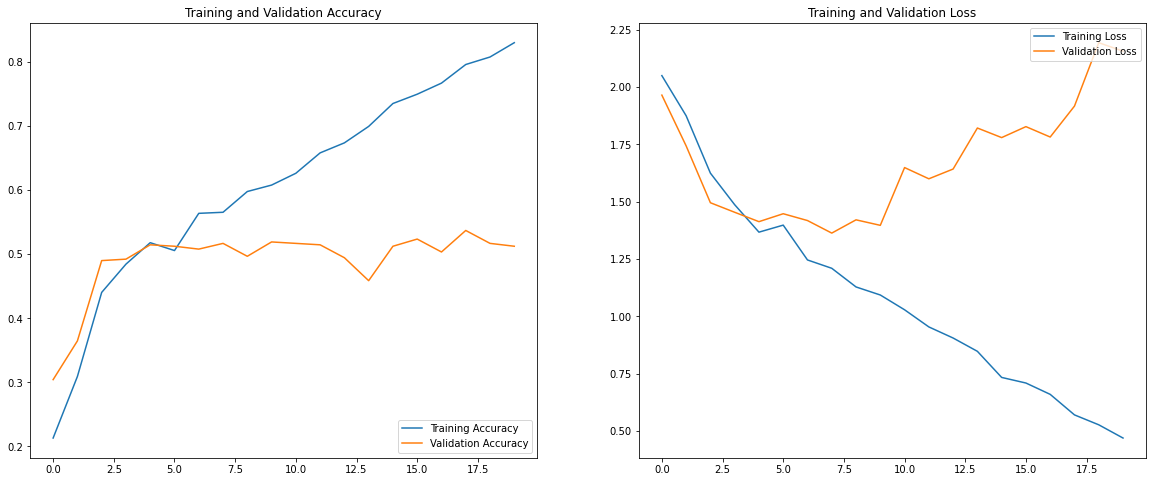

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig(PLOTS_PATH+"initial_model_cnn_accuracies.png")
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

Model is overfitting and this can be observed from
   1. the huge gap between accuracies of train and validation sets
   2. training loss going towards zero or nullifying but validation loss keeps increasing inversely

In [20]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
num_classes = 9

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
])

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

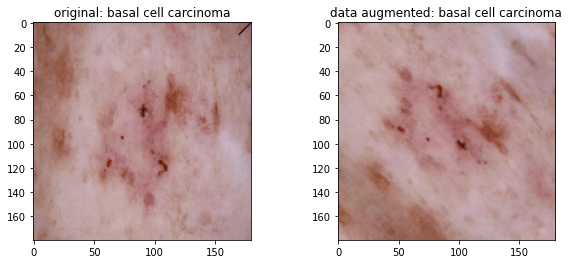

In [21]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
img, label = next(iter(train_ds))
plt.imshow(img[0].numpy().astype("uint8"))
_ = plt.title("original: "+class_names[label[0]])


plt.subplot(1, 2, 2)
plt.imshow(data_augmentation(img)[0].numpy().astype("uint8"))
_ = plt.title("data augmented: "+class_names[label[0]])

In [22]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 2s 29ms/step - loss: 1.9978 - accuracy: 0.2355 - val_loss: 1.7420 - val_accuracy: 0.3579
Epoch 2/20
56/56 [==============================] - 2s 30ms/step - loss: 1.7076 - accuracy: 0.3778 - val_loss: 1.6188 - val_accuracy: 0.4385
Epoch 3/20
56/56 [==============================] - 2s 30ms/step - loss: 1.5823 - accuracy: 0.4548 - val_loss: 1.5486 - val_accuracy: 0.4966
Epoch 4/20
56/56 [==============================] - 2s 30ms/step - loss: 1.5055 - accuracy: 0.4771 - val_loss: 1.5005 - val_accuracy: 0.4743
Epoch 5/20
56/56 [==============================] - 2s 30ms/step - loss: 1.4091 - accuracy: 0.5089 - val_loss: 1.3827 - val_accuracy: 0.5324
Epoch 6/20
56/56 [==============================] - 2s 30ms/step - loss: 1.3753 - accuracy: 0.5206 - val_loss: 1.4044 - val_accuracy: 0.5257
Epoch 7/20
56/56 [==============================] - 2s 30ms/step - loss: 1.3680 - accuracy: 0.5206 - val_loss: 1.3594 - val_accuracy: 0.5347
Epoch 8/20
56

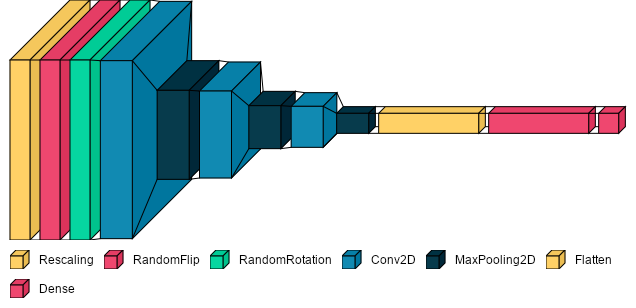

In [23]:
visualize_model(model=model, save_loc="model_with_data_aug.png")

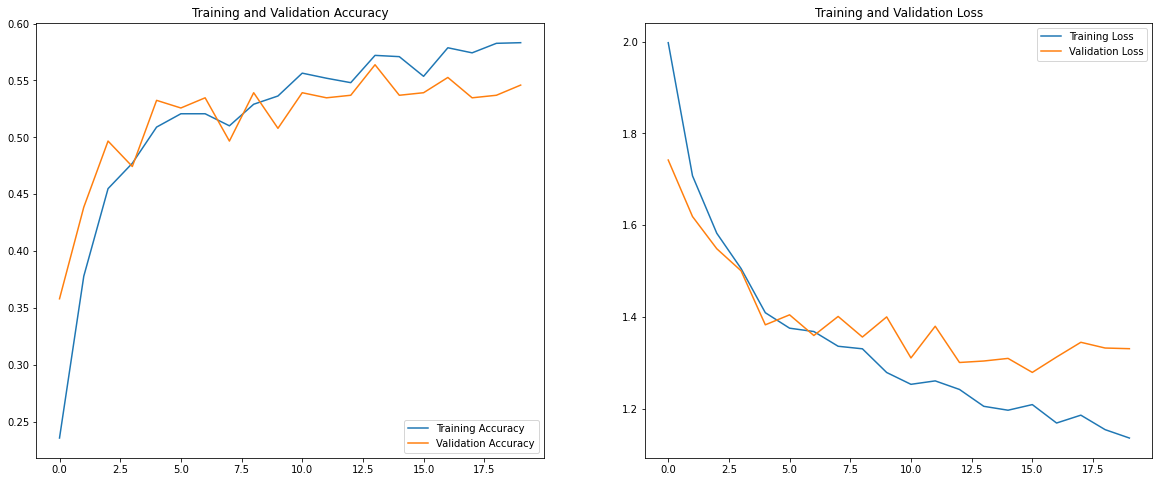

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig(PLOTS_PATH+"model_with_data_aug_accuracies.png")
plt.show()

### Todo:
### Create the model, compile and train the model


In [25]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

num_classes = 9

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(num_classes)
])

### Compiling the model

In [26]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [27]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 2s 31ms/step - loss: 2.1612 - accuracy: 0.1802 - val_loss: 2.1300 - val_accuracy: 0.1924
Epoch 2/20
56/56 [==============================] - 2s 29ms/step - loss: 2.0451 - accuracy: 0.1964 - val_loss: 1.9908 - val_accuracy: 0.2125
Epoch 3/20
56/56 [==============================] - 2s 29ms/step - loss: 1.9460 - accuracy: 0.2561 - val_loss: 1.8566 - val_accuracy: 0.3221
Epoch 4/20
56/56 [==============================] - 2s 29ms/step - loss: 1.7913 - accuracy: 0.3488 - val_loss: 1.8170 - val_accuracy: 0.3221
Epoch 5/20
56/56 [==============================] - 2s 29ms/step - loss: 1.7536 - accuracy: 0.3711 - val_loss: 1.7389 - val_accuracy: 0.4385
Epoch 6/20
56/56 [==============================] - 2s 29ms/step - loss: 1.6897 - accuracy: 0.4007 - val_loss: 1.6690 - val_accuracy: 0.4251
Epoch 7/20
56/56 [==============================] - 2s 29ms/step - loss: 1.6266 - accuracy: 0.4241 - val_loss: 1.6965 - val_accuracy: 0.4295
Epoch 8/20
56

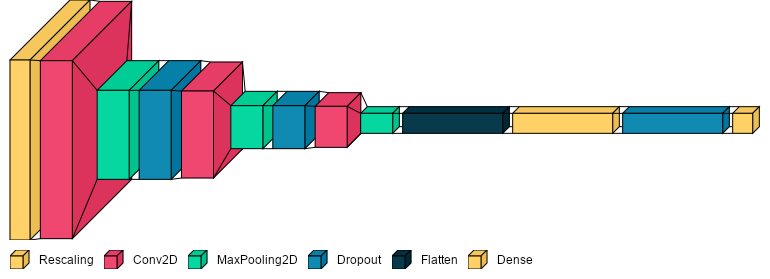

In [28]:
visualize_model(model=model, save_loc="model_with_dropout.png")

### Visualizing the results

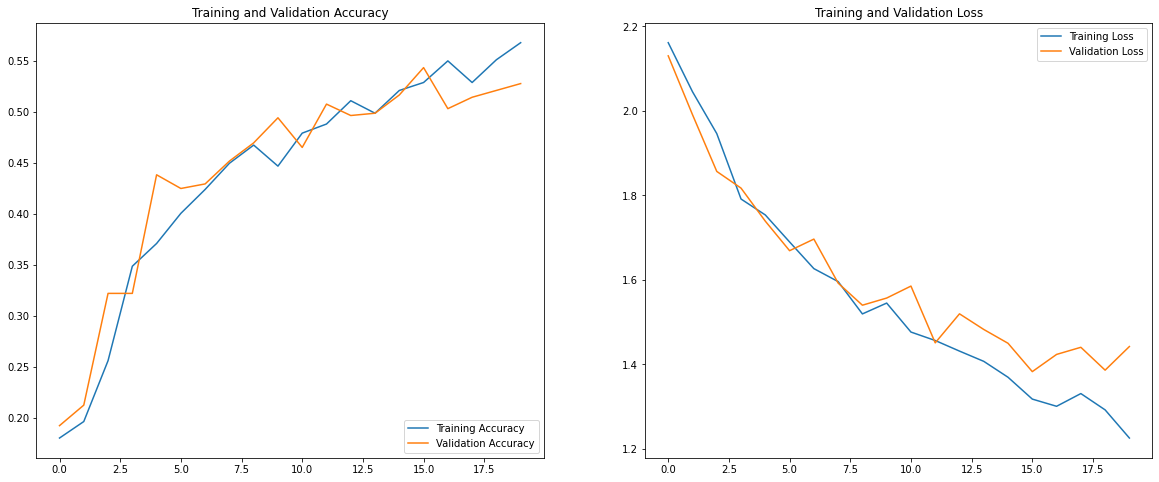

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig(PLOTS_PATH+"model_with_dropout_accuracies.png")
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

There is no overfit happening in the training, but accuracy is too low

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

total values:  1792
   label_id                       label  count
6         6        seborrheic keratosis     58
2         2              dermatofibroma     77
0         0           actinic keratosis     92
8         8             vascular lesion    115
7         7     squamous cell carcinoma    142
4         4                       nevus    277
1         1        basal cell carcinoma    309
3         3                    melanoma    352
5         5  pigmented benign keratosis    370


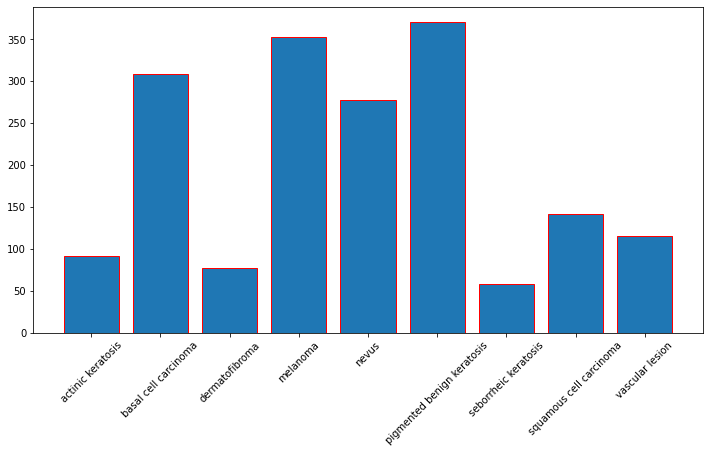

In [30]:
## Your code goes here.
def count_class(counts, batch, num_classes=9):
    # print(batch[1])
    labels = batch[1] #['label']
    for i in range(num_classes):
        cc = tf.cast(labels == i, tf.int32)
        counts[i] += tf.reduce_sum(cc)
    return counts

initial_state = dict((i, 0) for i in range(num_classes))
counts = train_ds.reduce(initial_state=initial_state,
                         reduce_func=count_class)

freq_label_tuple = [(ix, class_names[ix], val.numpy()) for ix, val in counts.items()]
res = 0
for k, v in counts.items():
    res += v.numpy()

print("total values: ", res)

freq_label_df = pd.DataFrame(freq_label_tuple, columns=["label_id", "label", "count"])

print(freq_label_df.sort_values(by=['count']).head(10))

plt.figure(figsize=(12, 6))
plt.bar(x=freq_label_df["label_id"], height=freq_label_df["count"], edgecolor='red')
plt.xticks(ticks=freq_label_df["label_id"], labels=freq_label_df["label"], rotation=45)
plt.savefig(PLOTS_PATH+"class_distrib_initial.png")
plt.show()

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
Class seborrheic keratosis has least number of samples i.e., 58

#### - Which classes dominate the data in terms proportionate number of samples?
pigmented benign keratosis, melanoma, basal cell carcinom, nevus has dominate the data in terms proportionate number of samples

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [31]:
if not verify_installation(package="Augmentor"):
    !pip install visualkeras

import Augmentor

Augmentor package installed already


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [32]:
path_to_training_dataset=DATA_PATH+"/Train/"
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.set_seed(123) # added seed to maintain results same
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to ../data//Train/actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x22EDF5D32B0>: 100%|█| 500/500 [00:01<00:00, 406.83 Samples


Initialised with 376 image(s) found.
Output directory set to ../data//Train/basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x22EDF7B5D90>: 100%|█| 500/500 [00:01<00:00, 445.63 Samples


Initialised with 95 image(s) found.
Output directory set to ../data//Train/dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x22EDF79D100>: 100%|█| 500/500 [00:01<00:00, 465.12 Samples


Initialised with 438 image(s) found.
Output directory set to ../data//Train/melanoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=3072x2304 at 0x22EDF5DA160>: 100%|█| 500/500 [00:06<0


Initialised with 357 image(s) found.
Output directory set to ../data//Train/nevus\output.

Processing <PIL.Image.Image image mode=RGB size=1504x1129 at 0x22EDF359130>: 100%|█| 500/500 [00:06<00:00, 77.27 Sample


Initialised with 462 image(s) found.
Output directory set to ../data//Train/pigmented benign keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x22DC7726160>: 100%|█| 500/500 [00:01<00:


Initialised with 77 image(s) found.
Output directory set to ../data//Train/seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x22EDF088760>: 100%|█| 500/500 [00:02<00:00, 195.69 Sample


Initialised with 181 image(s) found.
Output directory set to ../data//Train/squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x22EDF2CF3D0>: 100%|█| 500/500 [00:01<00:00, 437.06 Samples


Initialised with 139 image(s) found.
Output directory set to ../data//Train/vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x22EDF0754C0>: 100%|█| 500/500 [00:01<00:00, 424.81 Samples


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [33]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [34]:
from glob import glob

path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list[:10]

['..\\data\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_788cacf9-61d4-4b81-9903-bacb2c7d031c.jpg',
 '..\\data\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_907132cb-8f80-4f41-a289-3f8556e5525d.jpg',
 '..\\data\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_90e0ad80-6fa4-4709-bfc6-d85a2180943a.jpg',
 '..\\data\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_fa07c715-6c0d-471b-9c0a-77361a9363ff.jpg',
 '..\\data\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_10e63a5d-9cfa-47ab-a173-c77487af0e1c.jpg',
 '..\\data\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_1ec4cccc-cf94-41c7-8ec1-b8a8cc2ff512.jpg',
 '..\\data\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_31c13ca1-6592-4021-a562-9cc7f906a8d3.jpg',
 '..\\data\\Train\\actinic keratosis\\output\\actinic keratosis_origi

In [35]:
path_list_new = [
    (
        path_list_ix,
        os.path.basename(path_list_ix),
        os.path.basename(os.path.dirname(os.path.dirname(path_list_ix)))
    )
    for path_list_ix in path_list
]

In [36]:
df2 = pd.DataFrame(path_list_new,columns = ['Path','Image', 'Label'])
df2.sample(5)

,Path,Image,Label
2391,..\data\Train\nevus\output\nevus_original_ISIC...,nevus_original_ISIC_0000535.jpg_d678772c-01e1-...,nevus
771,..\data\Train\basal cell carcinoma\output\basa...,basal cell carcinoma_original_ISIC_0028583.jpg...,basal cell carcinoma
2730,..\data\Train\pigmented benign keratosis\outpu...,pigmented benign keratosis_original_ISIC_00263...,pigmented benign keratosis
2152,..\data\Train\nevus\output\nevus_original_ISIC...,nevus_original_ISIC_0000318.jpg_9671c36a-aff6-...,nevus
3438,..\data\Train\seborrheic keratosis\output\sebo...,seborrheic keratosis_original_ISIC_0011161.jpg...,seborrheic keratosis


In [37]:
df2['Label'].value_counts()

actinic keratosis             500
basal cell carcinoma          500
dermatofibroma                500
melanoma                      500
nevus                         500
pigmented benign keratosis    500
seborrheic keratosis          500
squamous cell carcinoma       500
vascular lesion               500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

In [38]:
## move samples
from tqdm.notebook import tqdm
import shutil


dest_folder = "../data/train_samples/"

# handles multiple notebook runs if samples are already present
# by deleting existing generated samples
shutil.rmtree(dest_folder, ignore_errors=True)
os.makedirs(dest_folder, exist_ok=True)

# handle folder creation to be inferred as labels
[os.makedirs(dest_folder+label, exist_ok=True) for label in os.listdir("../data/Train/")]

for each_fp in tqdm(df2["Path"].tolist()):
    label, each_fn = os.path.basename(os.path.dirname(os.path.dirname(each_fp))), os.path.basename(each_fp)
    os.rename(each_fp.replace("\\", "/"), dest_folder+f"{label}/{each_fn}")

  0%|          | 0/4500 [00:00<?, ?it/s]

In [39]:
len(glob(dest_folder+"*/*.jpg"))

4500

#### **Todo**: Train the model on the data created using Augmentor

In [40]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [41]:
data_dir_train=DATA_PATH+"/train_samples/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4500 files belonging to 9 classes.
Using 3600 files for training.


#### **Todo:** Create a validation dataset

In [42]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4500 files belonging to 9 classes.
Using 900 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [43]:
## your code goes here
num_classes = 9

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(num_classes)
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [44]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [45]:
## Your code goes here, use 50 epochs.
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
)

Epoch 1/50
113/113 [==============================] - 6s 48ms/step - loss: 2.2653 - accuracy: 0.1219 - val_loss: 2.1798 - val_accuracy: 0.1344
Epoch 2/50
113/113 [==============================] - 5s 41ms/step - loss: 1.9480 - accuracy: 0.2497 - val_loss: 1.7723 - val_accuracy: 0.3344
Epoch 3/50
113/113 [==============================] - 5s 41ms/step - loss: 1.7394 - accuracy: 0.3203 - val_loss: 1.8050 - val_accuracy: 0.3189
Epoch 4/50
113/113 [==============================] - 5s 41ms/step - loss: 1.6178 - accuracy: 0.3556 - val_loss: 1.8363 - val_accuracy: 0.3078
Epoch 5/50
113/113 [==============================] - 5s 41ms/step - loss: 1.5505 - accuracy: 0.3853 - val_loss: 1.5268 - val_accuracy: 0.4011
Epoch 6/50
113/113 [==============================] - 5s 41ms/step - loss: 1.4332 - accuracy: 0.4311 - val_loss: 1.4298 - val_accuracy: 0.4511
Epoch 7/50
113/113 [==============================] - 5s 40ms/step - loss: 1.4266 - accuracy: 0.4472 - val_loss: 1.3932 - val_accuracy: 0.4611

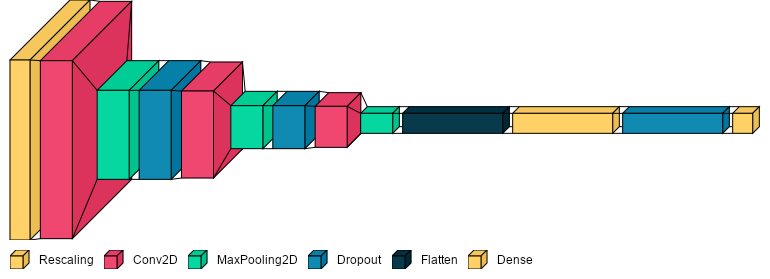

In [46]:
visualize_model(model=model, save_loc="model_with_class_rebalance.png")

#### **Todo:**  Visualize the model results

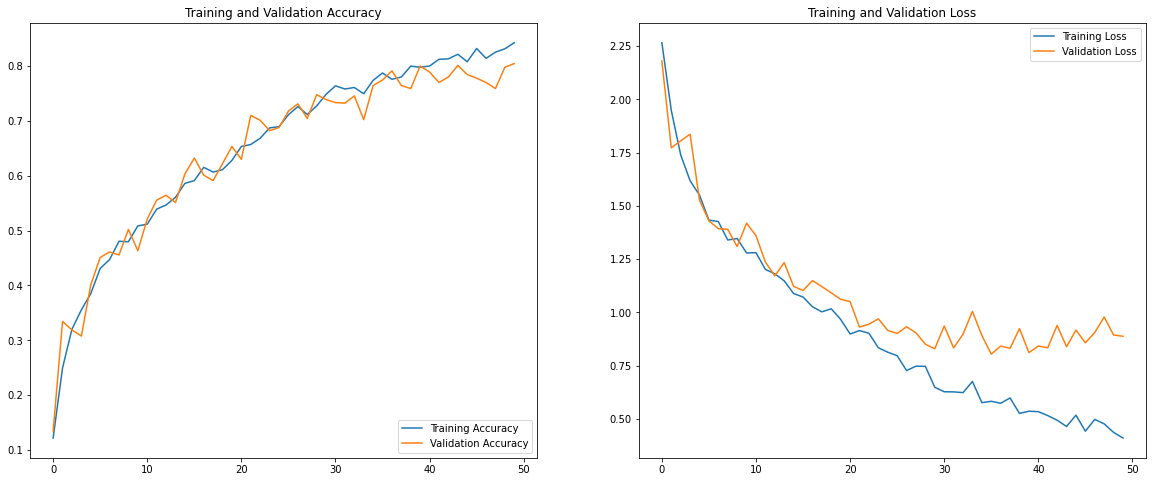

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig(PLOTS_PATH+"model_with_class_rebalance_accuracies.png")
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



- The model with dropouts trained on rebalanced classes is not overfitting and accuracy also looks better compared to earlier models.
- Class rebalancing did help with overfitting